# Project: Handwritten Digits Recognition Web App

# Table of Contents
* [Introduction](#introduction)
* [Data Preprocessing](#data_preprocessing)
    1. Missing Values Check
    2. MaxAbs Scaling
    3. Adjusting Shape And Dimensions
    4. Class Imbalance Check
    5. OneHot Encoding
    6. Data augmentation
* [Modified LeNet-5](#Modified-LeNet-5)
    * Structuring
    * Training
    * Evalution
    * Saving

# Introduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,classification_report
from sklearn.preprocessing import maxabs_scale

In [3]:
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets,layers, Sequential ,callbacks,metrics,losses,optimizers

## Used Libraries

In [4]:
from sklearn import __version__ as skv
from matplotlib import __version__ as pltv
from numpy import __version__ as npv
from seaborn import __version__ as snsv
from tensorflow.keras import __version__ as ksv
from flask import __version__ as fkv
from cv2 import __version__ as cvv

print(f'{"Numpy":15} {npv}')
print(f'{"Matplotlib":15} {pltv}')
print(f'{"Seaborn":15} {snsv}')
print(f'{"Scikit-Learn":15} {skv}')
print(f'{"Keras":15} {ksv}')
print(f'{"Flask":15} {fkv}')
print(f'{"OpenCV":15} {cvv}')


Numpy           1.19.5
Matplotlib      3.4.2
Seaborn         0.11.1
Scikit-Learn    0.24.2
Keras           2.5.0
Flask           2.0.1
OpenCV          4.5.3


# Data Preprocessing

In [5]:
(x_train,y_train),(x_test,y_test) = datasets.mnist.load_data()


In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
y_train.shape

(60000,)

In [8]:
x_test.shape

(10000, 28, 28)

In [9]:
y_test.shape

(10000,)

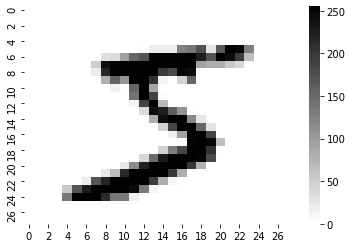

In [37]:
sns.heatmap(x_train[0],cmap='gray_r')
plt.show()

# Missing values Check

In [10]:
np.isnan(x_train).any()

False

In [11]:
np.isnan(y_train).any()

False

In [12]:
np.isnan(x_test).any()

False

In [13]:
np.isnan(y_test).any()

False

# MaxAbs Scaling

In [14]:
x_train[0].max()

255

In [15]:
x_train_scaled = np.array([maxabs_scale(x) for x in x_train])
x_test_scaled = np.array([maxabs_scale(x) for x in x_test])

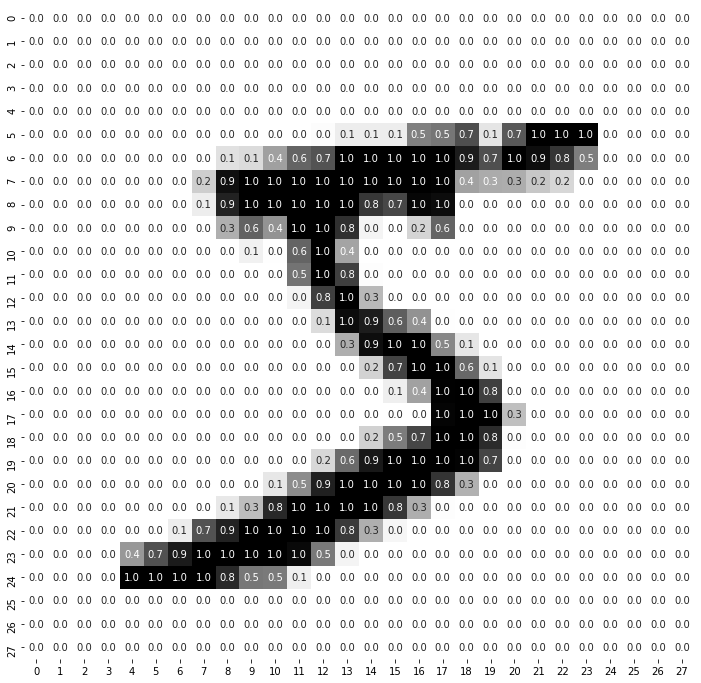

In [16]:
plt.figure(figsize=(12,12))
sns.heatmap(x_train_scaled[0],annot=True,cbar=False,cmap='gray_r',fmt='.1f')
plt.show()

# Adjusting Shape And Dimensions

In [17]:
x_train_scaled = np.expand_dims(x_train_scaled,axis=-1)
x_test_scaled = np.expand_dims(x_test_scaled,axis=-1)

In [18]:
x_train_scaled = np.pad(x_train_scaled, ((0,0),(2,2),(2,2),(0,0)), 'constant')
x_test_scaled = np.pad(x_test_scaled, ((0,0),(2,2),(2,2),(0,0)), 'constant')

In [19]:
x_train_scaled.shape

(60000, 32, 32, 1)

In [20]:
x_test_scaled.shape

(10000, 32, 32, 1)

# OneHot Encoding

In [21]:
y_train_OneHot = to_categorical(y_train, num_classes = 10)
y_test_OneHot = to_categorical(y_test, num_classes = 10)

In [22]:
y_train_OneHot.shape

(60000, 10)

In [23]:
y_test_OneHot.shape

(10000, 10)

# Class Imbalance Check

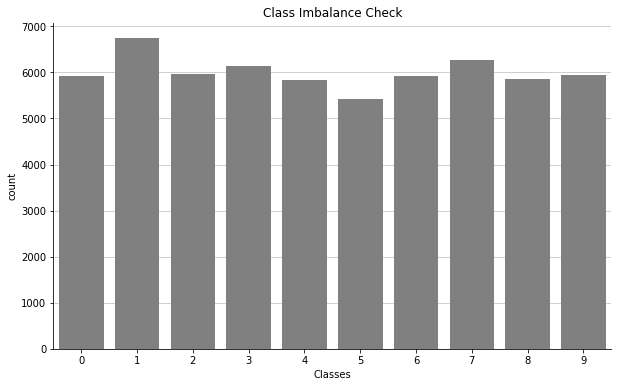

In [24]:
plt.figure(figsize=(10,6))
sns.countplot(x=y_train,color='#808080')
plt.title('Class Imbalance Check')
plt.xlabel('Classes')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.grid(axis='y', alpha=0.75)
plt.gca().set_axisbelow(True)
plt.show()

# Data augmentation

In [25]:
datagen = ImageDataGenerator(rotation_range=10,zoom_range = 0.1,width_shift_range=0.1,height_shift_range=0.1)
datagen.fit(x_train_scaled)       

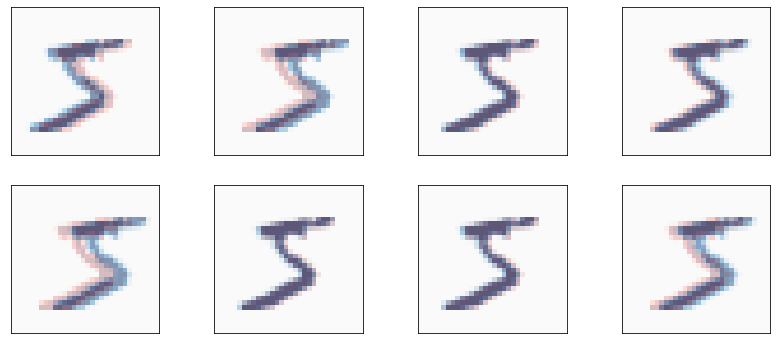

In [26]:
datagen = ImageDataGenerator(width_shift_range=0.1)
aug_iter = datagen.flow(np.expand_dims(x_train_scaled[0],axis=0), batch_size=1)
fig,ax = plt.subplots(2,4,figsize=(14,6))
for i in range(2):
    for j in range(4):
        ax[i,j].imshow(x_train_scaled[0],cmap='Reds',alpha=0.5)
        image = aug_iter.next()[0].astype(float)
        ax[i,j].imshow(image,cmap='Blues',alpha=0.5)
        ax[i,j].yaxis.set_visible(False)
        ax[i,j].xaxis.set_visible(False)
plt.show()

# Modified LeNet-5

## Structuring

In [27]:
from tensorflow.keras.regularizers import l2

model = Sequential()

model.add(layers.Conv2D(filters = 6, kernel_size = (5,5),padding='valid', input_shape = (32,32,1),kernel_regularizer=l2(0.0005)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(layers.Conv2D(filters = 16, kernel_size = (5,5),padding='valid',kernel_regularizer=l2(0.0005)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(layers.Flatten())

model.add(layers.Dense(units = 250))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(units = 120))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(units = 84))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))


model.add(layers.Dense(units = 10, activation = 'softmax'))

## Training

In [28]:
learning_rate_reduction = callbacks.ReduceLROnPlateau(monitor='val_loss',patience=2,factor=0.1,min_lr=0.00001)
optimizer = optimizers.Adam(learning_rate=0.01,beta_1=0.9,beta_2=0.999,epsilon=1e-7)
loss = losses.CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(datagen.flow(x_train_scaled,y_train_OneHot,batch_size=100,), 
                    epochs = 30, 
                    validation_data = (x_test_scaled,y_test_OneHot),
                    callbacks=[learning_rate_reduction],
                    verbose = 1)

Epoch 1/30
600/600 [==============================] - 48s 73ms/step - loss: 0.1976 - accuracy: 0.9449 - val_loss: 0.0813 - val_accuracy: 0.9820
Epoch 2/30
600/600 [==============================] - 48s 79ms/step - loss: 0.1201 - accuracy: 0.9715 - val_loss: 0.1045 - val_accuracy: 0.9767
Epoch 3/30
600/600 [==============================] - 47s 78ms/step - loss: 0.1053 - accuracy: 0.9764 - val_loss: 0.1486 - val_accuracy: 0.9606
Epoch 4/30
600/600 [==============================] - 48s 79ms/step - loss: 0.0679 - accuracy: 0.9870 - val_loss: 0.0410 - val_accuracy: 0.9935
Epoch 5/30
600/600 [==============================] - 48s 80ms/step - loss: 0.0567 - accuracy: 0.9882 - val_loss: 0.0373 - val_accuracy: 0.9938
Epoch 6/30
600/600 [==============================] - 48s 80ms/step - loss: 0.0507 - accuracy: 0.9897 - val_loss: 0.0329 - val_accuracy: 0.9936
Epoch 7/30
600/600 [==============================] - 44s 74ms/step - loss: 0.0480 - accuracy: 0.9895 - val_loss: 0.0343 - val_accuracy:

## Evaluation

In [29]:
y_pred = np.argmax(model.predict(x_test_scaled), axis=-1)

In [30]:
print(f'{"accuracy":10} {(y_pred == y_test).mean():.4f}')
print(f'{"precision":10} {precision_score(y_test,y_pred,average="macro"):.4f}')
print(f'{"recall":10} {recall_score(y_test,y_pred,average="macro"):.4f}')

accuracy   0.9944
precision  0.9944
recall     0.9943


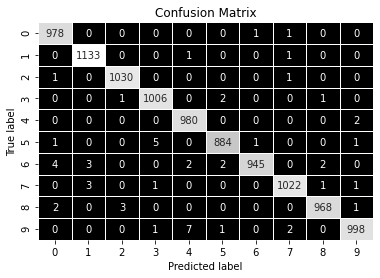

In [31]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cbar=False,fmt="d",linewidths=.5,cmap='gray')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

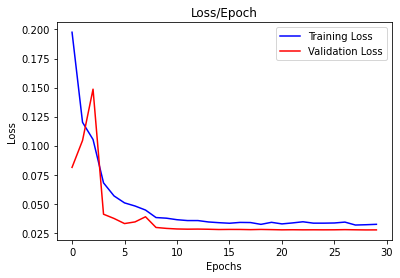

In [32]:
plt.plot(history.epoch,history.history['loss'],color='blue',label='Training Loss')
plt.plot(history.epoch,history.history['val_loss'],color='red',label='Validation Loss')
plt.title('Loss/Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

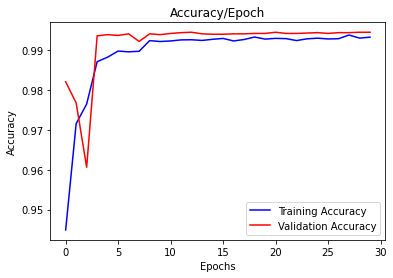

In [33]:
plt.plot(history.epoch,history.history['accuracy'],color='blue',label='Training Accuracy')
plt.plot(history.epoch,history.history['val_accuracy'],color='red',label='Validation Accuracy')
plt.title('Accuracy/Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Saving

In [34]:
data_dir = 'trained_models'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
model.save(f'{data_dir}/modified_LeNet_5.h5')